In [355]:
import os
os.chdir('/content/drive/My Drive/DL data/Deep NN')

In [356]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

Let's write two helper functions that will initialize the parameters for your model. The first function will be used to initialize parameters for a two layer model. The second one will generalize this initialization process to  L  layers:

In [357]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters 

In [358]:
def initialize_parameters_deep(layer_dims):      # layer_dims = python array (list) containing the dimensions of each layer in our network
    parameters = {}
    L = len(layer_dims)   # number of layers in the network

    for l in range(1, L):     # looping starts from 1 to exclude the input layer
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])   # *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

Forward propagation:

In [359]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

Linear activation functions - sigmoid and ReLU:

In [360]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [361]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 

    return A, cache

In [362]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

Forward propagation:

In [363]:
def L_model_forward(X, parameters):      # X = input and parameters = output of initialize_parameters_deep()
    caches = []
    A = X
    L = len(parameters) // 2     # number of layers in the neural network because parameters has W1, b1 for 1st layer and so on

    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')    # All the hidden layers use relu activation
        caches.append(cache)                                                                                                   
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')    # Output layer uses sigmoid 
    caches.append(cache)
            
    return AL, caches

Cross Entropy cost function:

In [364]:
def compute_cost(AL, Y):
    m = Y.shape[1]     # number of training examples
    cost = (-1/m) * np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))
    return cost

Back propagation, We define two functions : linear_backward and the backward step for the activation linear_activation_backward

In [365]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)   # dW = d(cost)/dW and so on
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)   
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [366]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [367]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)      # just converting dz to a correct object.
    
    # When z <= 0, set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    return dZ

In [368]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

Now we go: Output --> Sigmoid --> Linear --> ReLU --> Linear:

In [369]:
def L_model_backward(AL, Y, caches):    # caches -- list of caches containing: 1. every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                                                                           #   2. the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    grads = {}
    L = len(caches)      # the number of layers in the network
    m = AL.shape[1]      # total number of training examples
    Y = Y.reshape(AL.shape)     # Now, Y is the same shape as AL

    dAL = dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))    # d(cost)/d(AL)

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation='sigmoid')   # dAL = dA of the output layer

    # Loop from l = L-2 to l = 0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation='relu')   # grads["dA" + str(l + 1)] = dA of the next layer
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

Update the parameters:

In [370]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW'+ str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db'+ str(l+1)]

    return parameters

Now, we'll build an image classifier using these functions. Train and test data are in .h5 format. Access them by h5py library. There are 209 training images of size 64x64 with 3 channels. 209 training labels (0: non-cat or 1: cat). Similarly, 50 test images of size 64x64 with 3 channels and 50 test labels (0: non-cat or 1: cat).

In [371]:
with h5py.File('/content/drive/My Drive/DL data/catvsnoncat/train_catvnoncat.h5', "r") as train_dataset:
    train_x_orig = np.array(train_dataset["train_set_x"][:])
    train_y_orig = np.array(train_dataset["train_set_y"][:])

with h5py.File('/content/drive/My Drive/DL data/catvsnoncat/test_catvnoncat.h5', "r") as test_dataset:
    test_x_orig = np.array(test_dataset["test_set_x"][:])
    test_y_orig = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])

print(train_x_orig.shape)
print(train_y_orig.shape)
print(test_x_orig.shape)
print(test_y_orig.shape)


(209, 64, 64, 3)
(209,)
(50, 64, 64, 3)
(50,)


y = 1. It's a cat picture.


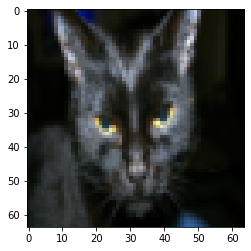

In [372]:
index = 25
plt.imshow(train_x_orig[index])
print("y = " + str(train_y_orig[index]) + ". It's a " + classes[train_y_orig[index]].decode("utf-8") +  " picture.")

Flatten the data to convert it into a vector:

In [373]:
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_y = train_y_orig.reshape((1, train_y_orig.shape[0]))
test_y = test_y_orig.reshape((1, test_y_orig.shape[0]))

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(12288, 209)
(12288, 50)
(1, 209)
(1, 50)


Standardize the data set:

In [374]:
train_x = train_x/255. 
test_x = test_x/255.

We will build two different models - A 2-layer neural network and an L-layer deep neural network:

In [375]:
n_x = 12288    # number of features
n_h = 7    # number of hidden units
n_y = 1    # number of output units
layers_dims = (n_x, n_h, n_y)

Model 1 - two layer model:

In [376]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    grads = {}
    costs = []        # to keep track of the cost
    m = X.shape[1]    # number of training examples
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        
        # Forward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Store the gradients in grads with the corresponding name
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
       
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6934417915902951
Cost after iteration 100: 0.6471006411365473
Cost after iteration 200: 0.6348660445275538
Cost after iteration 300: 0.6074053573273522
Cost after iteration 400: 0.56853252251732
Cost after iteration 500: 0.5290057052390119
Cost after iteration 600: 0.4898414835158636
Cost after iteration 700: 0.4613922320328614
Cost after iteration 800: 0.4252085740389685
Cost after iteration 900: 0.39793624035442804
Cost after iteration 1000: 0.36481138300263605
Cost after iteration 1100: 0.3321791028033744
Cost after iteration 1200: 0.282708226643849
Cost after iteration 1300: 0.2528528299894745
Cost after iteration 1400: 0.21536059888854353
Cost after iteration 1500: 0.18605007993866746
Cost after iteration 1600: 0.31216575148728526
Cost after iteration 1700: 0.1269863210145678
Cost after iteration 1800: 0.10743261341030622
Cost after iteration 1900: 0.10240198267753915
Cost after iteration 2000: 0.0774386577962279
Cost after iteration 2100: 0.0686067313370

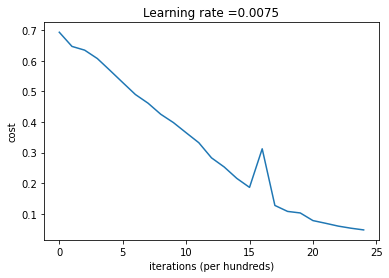

In [377]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500)

This function is used to predict the results of a  L-layer neural network:

In [378]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2     # number of layers in the neural network
    p = np.zeros((1,m))      # predictions for the given dataset X
     
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))    
    return p

Now, let's use the trained parameters to classify images from the dataset:

In [379]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [380]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.68


Model 2: L-layer model:

In [381]:
layers_dims = [12288, 20, 7, 5, 1]     # 4-layer model

In [382]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    costs = []     # keep track of cost
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        AL, caches = L_model_forward(X, parameters)
       
        # Compute cost
        cost = compute_cost(AL, Y)
        
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.695003
Cost after iteration 100: 0.663719
Cost after iteration 200: 0.619045
Cost after iteration 300: 0.563908
Cost after iteration 400: 0.491216
Cost after iteration 500: 0.460253
Cost after iteration 600: 0.424897
Cost after iteration 700: 0.356382
Cost after iteration 800: 0.243024
Cost after iteration 900: 0.171161
Cost after iteration 1000: 0.127543
Cost after iteration 1100: 0.057659
Cost after iteration 1200: 0.035566
Cost after iteration 1300: 0.025717
Cost after iteration 1400: 0.019510
Cost after iteration 1500: 0.015402
Cost after iteration 1600: 0.012516
Cost after iteration 1700: 0.010405
Cost after iteration 1800: 0.008801
Cost after iteration 1900: 0.007579
Cost after iteration 2000: 0.006611
Cost after iteration 2100: 0.005840
Cost after iteration 2200: 0.005207
Cost after iteration 2300: 0.004678
Cost after iteration 2400: 0.004236


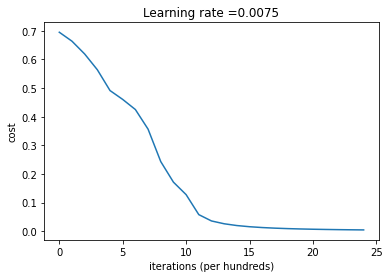

In [383]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500)

In [384]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [385]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78


**Yay! it seems that the 4-layer neural network has better performance than the 2-layer neural network on the same test set.**